In [18]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import fbeta_score, make_scorer, precision_recall_curve, auc, accuracy_score, roc_curve
from xgboost.sklearn import XGBClassifier
import joblib
from modeling_helper import create_xy, search_result, get_important_feature
import matplotlib.pyplot as plt

In [2]:
flights = pd.read_csv('/Users/user/Documents/Github/flightstatus/data/dev/flights_processed.csv')

In [3]:
datatrainval, datatest= train_test_split(flights, stratify = flights['TARGET'], test_size=0.25, random_state=12)
datatrain, dataval = train_test_split(datatrainval, stratify = datatrainval['TARGET'], test_size=0.3, random_state=12)

In [4]:
X_train, y_train = create_xy(datatrain)
X_val, y_val = create_xy(dataval)
X_test, y_test = create_xy(datatest)

### Starting model

`scale_pos_weight` is the ratio of number of negative class to the positive class. 

In [7]:
spw = (sum(y_train==0) + sum(y_val==0))/(sum(y_train==1)+sum(y_val==1))
metric='aucpr'

In [8]:
m_xgb = XGBClassifier(max_depth=5,
                      min_child_weight=5,
                      subsample=0.8,
                      colsample_bytree=0.8,
                      learning_rate = 1,
                      reg_alpha = 0, reg_lambda = 0, gamma=0,
                      scale_pos_weight=spw,
                      objective= 'binary:logistic',
                      random_state=123,
                      n_jobs=-1, n_estimators = 999)

m_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
          eval_metric=[metric], early_stopping_rounds=5, verbose=True)

[0]	validation_0-aucpr:0.487414	validation_1-aucpr:0.48794
Multiple eval metrics have been passed: 'validation_1-aucpr' will be used for early stopping.

Will train until validation_1-aucpr hasn't improved in 5 rounds.
[1]	validation_0-aucpr:0.501738	validation_1-aucpr:0.502125
[2]	validation_0-aucpr:0.517739	validation_1-aucpr:0.517958
[3]	validation_0-aucpr:0.523098	validation_1-aucpr:0.523461
[4]	validation_0-aucpr:0.525676	validation_1-aucpr:0.52575
[5]	validation_0-aucpr:0.528701	validation_1-aucpr:0.528787
[6]	validation_0-aucpr:0.530207	validation_1-aucpr:0.530201
[7]	validation_0-aucpr:0.533185	validation_1-aucpr:0.532635
[8]	validation_0-aucpr:0.539912	validation_1-aucpr:0.539595
[9]	validation_0-aucpr:0.54208	validation_1-aucpr:0.541753
[10]	validation_0-aucpr:0.54605	validation_1-aucpr:0.54554
[11]	validation_0-aucpr:0.548366	validation_1-aucpr:0.547655
[12]	validation_0-aucpr:0.549435	validation_1-aucpr:0.548624
[13]	validation_0-aucpr:0.551542	validation_1-aucpr:0.550592
[

[132]	validation_0-aucpr:0.59534	validation_1-aucpr:0.584951
[133]	validation_0-aucpr:0.595668	validation_1-aucpr:0.585201
[134]	validation_0-aucpr:0.595701	validation_1-aucpr:0.585182
[135]	validation_0-aucpr:0.595798	validation_1-aucpr:0.585221
[136]	validation_0-aucpr:0.595966	validation_1-aucpr:0.585343
[137]	validation_0-aucpr:0.596238	validation_1-aucpr:0.585577
[138]	validation_0-aucpr:0.596295	validation_1-aucpr:0.585628
[139]	validation_0-aucpr:0.596339	validation_1-aucpr:0.585577
[140]	validation_0-aucpr:0.596477	validation_1-aucpr:0.585588
[141]	validation_0-aucpr:0.596526	validation_1-aucpr:0.585559
[142]	validation_0-aucpr:0.596587	validation_1-aucpr:0.585578
[143]	validation_0-aucpr:0.596672	validation_1-aucpr:0.585583
Stopping. Best iteration:
[138]	validation_0-aucpr:0.596295	validation_1-aucpr:0.585628



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=1, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=None, n_estimators=999, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=123,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=1.9071632400592526,
              seed=None, silent=None, subsample=0.8, verbosity=1)

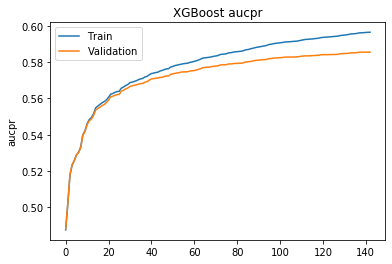

In [9]:
# retrieve performance metrics
results = m_xgb.evals_result()
epochs = len(results['validation_0'][metric])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0'][metric], label='Train')
ax.plot(x_axis, results['validation_1'][metric], label='Validation')
ax.legend()
plt.ylabel(metric)
plt.title('XGBoost '+metric)
plt.show()

### Hyperparameter Tuning with Random Search

In [22]:
parameter_grid = {
    'max_depth' : list(range(3,6)), 
    'min_child_weight': list(range(2,7)),
    'subsample' : [i/10.0 for i in range(8, 10)], 
    'colsample_bytree' : [i/10.0 for i in range(8, 10)],
    'learning_rate' : np.linspace(0.5,2,5)
}

number_models = 5
random_XGB_class = RandomizedSearchCV(estimator = XGBClassifier(max_depth=5,
                                      min_child_weight=5,
                                      subsample=0.8,
                                      colsample_bytree=0.8,
                                      learning_rate = 1,
                                      reg_alpha = 0, reg_lambda = 0, gamma=0,
                                      scale_pos_weight=spw,
                                      objective= 'binary:logistic',
                                      random_state=123,
                                      n_jobs=-1, n_estimators = 999), 
                                      
                                      param_distributions = parameter_grid, n_iter = number_models, 
                                      scoring='average_precision', cv = 10, return_train_score = False,
                                      n_jobs=-1)
random_XGB_class.fit(X_train, y_train, eval_set= [(X_val, y_val)], eval_metric=metric, early_stopping_rounds=5)

[0]	validation_0-aucpr:0.449992
Will train until validation_0-aucpr hasn't improved in 5 rounds.
[1]	validation_0-aucpr:0.43587
[2]	validation_0-aucpr:0.451038
[3]	validation_0-aucpr:0.463404
[4]	validation_0-aucpr:0.458177
[5]	validation_0-aucpr:0.462092
[6]	validation_0-aucpr:0.471135
[7]	validation_0-aucpr:0.455461
[8]	validation_0-aucpr:0.457856
[9]	validation_0-aucpr:0.459778
[10]	validation_0-aucpr:0.459502
[11]	validation_0-aucpr:0.457401
Stopping. Best iteration:
[6]	validation_0-aucpr:0.471135



RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=0.8, gamma=0,
                                           learning_rate=1, max_delta_step=0,
                                           max_depth=5, min_child_weight=5,
                                           missing=None, n_estimators=999,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=123, reg_alpha=0,
                                           reg_lambda=...
                                           subsample=0.8, verbosity=1),
                   iid='deprecated', n_iter=5, n_jobs=-1,
                   param_distributions={'colsamp

In [23]:
rs_result = search_result(random_XGB_class)
rs_result

,subsample,min_child_weight,max_depth,learning_rate,colsample_bytree,mean_score,std_score
2,0.8,6,3,1.625,0.9,0.452064,0.035071
4,0.9,6,4,0.875,0.9,0.428589,0.067398
3,0.8,3,4,0.875,0.9,0.426026,0.061418
0,0.9,4,3,0.875,0.8,0.421398,0.052723
1,0.9,3,5,1.250,0.9,0.405512,0.060550


### Hyperparameter Tuning with Grid Search

In [10]:
parameter_grid = {
    'max_depth' : [3, 5], 
    'learning_rate' : [1.0, 1.5]
}

grid_XGB_class = GridSearchCV(estimator = XGBClassifier(max_depth=5,
                                      min_child_weight=5,
                                      subsample=0.8,
                                      colsample_bytree=0.8,
                                      learning_rate = 1,
                                      reg_alpha = 0, reg_lambda = 0, gamma=0,
                                      scale_pos_weight=spw,
                                      objective= 'binary:logistic',
                                      random_state=123,
                                      n_jobs=-1, n_estimators = 999),
                                                        
                                      param_grid = parameter_grid, 
                                      scoring='average_precision', cv = 10, return_train_score = False,
                                      n_jobs=-1)
grid_XGB_class.fit(X_train, y_train, eval_set= [(X_val, y_val)], eval_metric=metric, early_stopping_rounds=5)

[0]	validation_0-aucpr:0.48794
Will train until validation_0-aucpr hasn't improved in 5 rounds.
[1]	validation_0-aucpr:0.502125
[2]	validation_0-aucpr:0.517958
[3]	validation_0-aucpr:0.523461
[4]	validation_0-aucpr:0.52575
[5]	validation_0-aucpr:0.528787
[6]	validation_0-aucpr:0.530201
[7]	validation_0-aucpr:0.532635
[8]	validation_0-aucpr:0.539595
[9]	validation_0-aucpr:0.541753
[10]	validation_0-aucpr:0.54554
[11]	validation_0-aucpr:0.547655
[12]	validation_0-aucpr:0.548624
[13]	validation_0-aucpr:0.550592
[14]	validation_0-aucpr:0.553668
[15]	validation_0-aucpr:0.554397
[16]	validation_0-aucpr:0.555202
[17]	validation_0-aucpr:0.556076
[18]	validation_0-aucpr:0.556704
[19]	validation_0-aucpr:0.55774
[20]	validation_0-aucpr:0.559019
[21]	validation_0-aucpr:0.560976
[22]	validation_0-aucpr:0.561234
[23]	validation_0-aucpr:0.561805
[24]	validation_0-aucpr:0.562115
[25]	validation_0-aucpr:0.562287
[26]	validation_0-aucpr:0.564019
[27]	validation_0-aucpr:0.564543
[28]	validation_0-aucpr:0

GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=1, max_delta_step=0,
                                     max_depth=5, min_child_weight=5,
                                     missing=None, n_estimators=999, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=123, reg_alpha=0,
                                     reg_lambda=0,
                                     scale_pos_weight=1.9071632400592526,
                                     seed=None, silent=None, subsample=0.8,
                                     verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [1.0, 1.5], 'max_depth': [3, 5]},
      

In [14]:
grid_XGB_class.best_estimator_.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=1.0, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=None, n_estimators=999, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=123,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=1.9071632400592526,
              seed=None, silent=None, subsample=0.8, verbosity=1)>

In [6]:
# joblib.dump(grid_XGB_class, 'grid_XGB_class')
grid_XGB_class = joblib.load('grid_XGB_class')

In [16]:
gs = search_result(grid_XGB_class)
gs

,learning_rate,max_depth,mean_score,std_score
1,1.0,5,0.582067,0.002117
0,1.0,3,0.576535,0.005045
3,1.5,5,0.561010,0.003919
2,1.5,3,0.557551,0.005402


### Get feature importance

In [17]:
imp_feat = get_important_feature(X_train.columns, grid_XGB_class.best_estimator_.feature_importances_)
imp_feat

,feature,importance_score
7,SCHEDULED_ARRIVAL,0.188849
23,AIRLINE_CAT,0.137544
0,MONTH,0.063733
16,AIRLINE_TRAFFIC,0.046381
6,DISTANCE,0.045211
14,DATE_TRAFFIC,0.038589
9,LONGITUDE_ORIGIN,0.038177
11,LONGITUDE_DESTINATION,0.034828
17,ORIGIN_AIRPORT_TRAFFIC,0.032723
1,DAY,0.031134


### Make predictions

In [8]:
m_xgb = grid_XGB_class.best_estimator_
y_train_prob = m_xgb.predict_proba(X_train)[:,1]
y_val_prob = m_xgb.predict_proba(X_val)[:,1]
y_test_prob = m_xgb.predict_proba(X_test)[:,1]

## ROC

In [20]:
fpr, tpr, thresholds = roc_curve(y_train, y_train_prob)
auc(fpr, tpr)

0.7336124398234709

In [21]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
auc(fpr, tpr)

0.7249644243416972

In [19]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
auc(fpr, tpr)

0.7249959136922439

### Precision-Recall Curve

In [23]:
precision, recall, thresholds = precision_recall_curve(y_train, y_train_prob)
auc(recall, precision)

0.5962947051828825

In [24]:
precision, recall, thresholds = precision_recall_curve(y_val, y_val_prob)
auc(recall, precision)

0.5856284475476635

In [12]:
precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
auc(recall, precision)

0.5853875632031357